In [1]:
#importing required odules and libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If yo

In [2]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 40
image_size = 72 # we'll resize the input to this size
patch_size = 6 # size of the patches to be extracted from the input images
num_patches = (image_size // patch_size)** 2
num_heads = 4
projection_dim = 64
transformer_units = [
    projection_dim*2,
    projection_dim
] # size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] # size of the dense layers of the final classifier


In [4]:
# Data Augmentation
data_augmentation =keras.Sequential(
[
    layers.Normalization(),
    layers.Resizing(image_size, image_size),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=0.02),
    layers.RandomZoom(
        height_factor = 0.2, width_factor = 0.2)
    ],
    name = "data_augmentation"
)
data_augmentation.layers[0].adapt(x_train)

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation = tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = "VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches,[batch_size, -1, patch_dims])
        return patches
        

image size: 72 X 72
patch size: 6 X 6
patches per image: 144
Elements per patch: 108


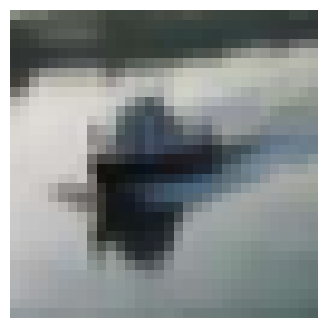

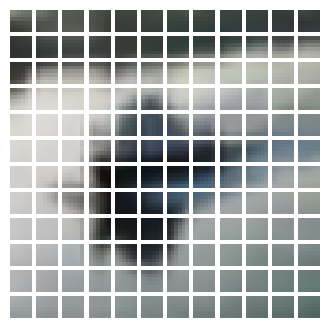

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image = x_train[np.random.choice(x_train.shape[0])]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size))
patches = Patches(patch_size)(resized_image)
print(f"image size: {image_size} X {image_size}")
print(f"patch size: {patch_size} X {patch_size}")
print(f"patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i+1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")
      

In [8]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = layers.Dense(units = projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim = num_patches,
            output_dim = projection_dim 
        )
        
    def call(self, patch):
        position = tf.range(start = 0, limit = self.num_patches, delta = 1)
        encoded = self.projection_dim(patch) + self.position_embedding(position)
        return encoded
    

In [9]:
def create_ViT_classifier():
    inputs = layers.Input(shape = input_shape)
    #augment data
    augmented = data_augmentation(inputs)
    # create patches
    patches = Patches(batch_size)(augmented)
    # encode Patches
    encode_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    # create multiple layers of the transformer block
    for _ in range(transformer_layers):
        # layers normalization
        x1 = layers.LayerNormalization(epsilon = 1e-6)(encode_patches)
        # create a multi head attension layer
        attention_output = layers.MultiHeadAttention(
            num_heads = num_heads, 
            key_dim = projection_dim,
            dropout = 0.1
        )(x1, x1)
        # skip ci=onnection
        x2 = layers.Add()([attention_output, encode_patches])
        # layer normalization
        x3 = layers.LayerNormalization(epsilon = 1e-6)(x2)
        #MLP
        x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)
        # skip connections2
        encoded_patches = layers.Add()([x3, x2])
        
    # Create 0 [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # add MLP
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)
    # classify output
    logits = layers.Dense(num_classes)(features)
    
    
    # create Keras
    model = keras.Model(inputs = inputs, outputs = logits)
    return model

In [16]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate = learning_rate, 
        weight_decay = weight_decay
    )
    model.compile(
        optimizer = optimizer, 
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = [
            keras.metrics.SparseCategoricalAccuracy(name = "Accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name = "TOp 5 accuracy")
    
        ]
    )
    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath, 
        monitor = "val_accuracy",
        save_best_only = True,
        save_weights_only = True,
    )
    history = model.fit(
        x = x_train,
        y = y_train,
        batch_size = batch_size,
        epochs = num_epochs,
        validation_split = 0.1,
        callbacks =[checkpoint_callback]
    )
    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"test accuracy = {round(accuracy*100, 2)}%")
    print(f"test top 5 accuracy = {round(top_5_accuracy*100, 2)}%")


In [18]:
vit_classifier = create_ViT_classifier()


In [19]:
history = run_experiment(vit_classifier)

Epoch 1/40


InvalidArgumentError: Graph execution error:

Detected at node model_2/patch_encoder_2/add defined at (most recent call last):
  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\runpy.py", line 197, in _run_module_as_main

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\runpy.py", line 87, in _run_code

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code

  File "C:\Users\Priyanshu Tiwari\AppData\Local\Temp\ipykernel_23860\1438931254.py", line 1, in <module>

  File "C:\Users\Priyanshu Tiwari\AppData\Local\Temp\ipykernel_23860\353485159.py", line 22, in run_experiment

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1150, in train_step

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\Priyanshu Tiwari\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\Priyanshu Tiwari\AppData\Local\Temp\ipykernel_23860\975647022.py", line 13, in call

Incompatible shapes: [256,0,64] vs. [144,64]
	 [[{{node model_2/patch_encoder_2/add}}]] [Op:__inference_train_function_23140]